In [1]:
# Reload the modules on kernel restart
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
from lyscripts.clean import lyprox_to_lymph
from util import set_size
import lymph
from lyscripts.helpers import add_tstage_marg
from lyscripts.clean import lyprox_to_lymph
from lyscripts.sample import run_mcmc_with_burnin
import emcee
import multiprocess as mp
import os

mp.set_start_method('fork', force=True)
os.environ["OMP_NUM_THREADS"] = "1"
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('/Users/juli/Studium/Master/FS23/masterthesis/code/styles/mplstyle_rl.txt')



Bad key xtick. in file /Users/juli/Studium/Master/FS23/masterthesis/code/styles/mplstyle_rl.txt, line 50 ('xtick.   : x-small')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.1/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Plotting styles
usz_blue = "#005ea8"
usz_blue_border = "#2387D5"
usz_green = "#00afa5"
usz_green_border = "#30DFD5"
usz_red = "#ae0060"
usz_red_border = "#FB4EAE"
usz_orange = "#f17900"
usz_orange_border = "#F8AB5C"
usz_gray = "#c5d5db"
usz_gray_border = "#DFDFDF"
#sn.set_theme()
colors = [usz_blue, usz_green, usz_red, usz_orange, usz_gray]
edge_colors = [usz_blue_border, usz_green_border, usz_red_border, usz_orange_border, usz_gray_border]


def create_models(n,  graph = None):
    if graph is None:
        graph = {
            ("tumor", "primary"): ["I", "II", "III", "IV"],
            ("lnl", "I"): [],
            ("lnl", "II"): ["I", "III"],
            ("lnl", "III"): ["IV"],
            ("lnl", "IV"): [],
        }

    diagnostic_spsn = {
        "max_llh": [1.0, 1.0],
    }


    max_t = 10
    first_binom_prob = 0.3

    models = []
    for i in range(n):
        model = lymph.Unilateral(graph)
        model.modalities = diagnostic_spsn
        add_tstage_marg(
            model,
            t_stages=["early", "late"],
            first_binom_prob=first_binom_prob,
            max_t=max_t,
        )
        models.append(model)
    if n>1:
        return models
    else:
        return models[0]

In [3]:
PLOT_PATH = Path("./figures/")

datasets_names = ["2022_CLB_multisite_enhanced.csv", "2022_CLB_oropharynx_enhanced.csv", "2022-ISB-multisite_enhanced.csv"]
dataset = pd.DataFrame({})
for ds in datasets_names:
    dataset_new = pd.read_csv(Path("../../data/datasets/enhanced/" + ds), header=[0, 1, 2])
    dataset = pd.concat([dataset, dataset_new], ignore_index=True)
print(f"Succesfully loaded {len(dataset)} Patients")

convert_t_stage = {
            0: "early",
            1: "early",
            2: "early",
            3: "late",
            4: "late"
        }
data = dataset[["tumor", "patient", "max_llh"]].copy()
t_stages = list(data[("tumor", "1", "t_stage")].apply(lambda t: convert_t_stage[t]))
#data["tumor", "1", "t_stage"] = t_stages
data[('info', 'tumor', 't_stage')] = t_stages
data.head()

Succesfully loaded 969 Patients


tumor                                                       patient  \
             1                                                             #   
      location subsite central extension volume t_stage stage_prefix      id   
0  hypopharynx     C12     NaN       NaN    NaN       2            p    2003   
1  oral cavity     C02     NaN       NaN    NaN       2            p    2004   
2       larynx     C32     NaN       NaN    NaN       2            p    2005   
3   oropharynx     C01     NaN       NaN    NaN       4            p    2006   
4  oral cavity     C02     NaN       NaN    NaN       2            p    2007   

               ... max_llh                                                   \
               ...  contra                                                    
      sex age  ...      Va VII     II     Ia   Vb     Ib  IIa     IV    III   
0    male  60  ...     NaN NaN  False  False  NaN  False  NaN  False  False   
1    male  52  ...     NaN NaN  False  False  NaN  False  NaN  False  False   
2    male  51  ...     NaN NaN  False  False  NaN  False  NaN  False  False   
3  female  49  ...     NaN NaN  False  False  NaN  False  NaN  False  False   
4    male  41  ...     NaN NaN  False  False  NaN  False  NaN  False  False   

     info  
    tumor  
  t_stage  
0   early  
1   early  
2   early  
3    late  
4   early  

[5 rows x 45 columns]

In [14]:
data_tf = lyprox_to_lymph(data)

In [15]:
# We only care for major subsites (e.g. subsites labels Cxx.yy are indexed as Cxx)
subsites_list = list(data['tumor']["1"]["subsite"])
major_subsites = [s[:3] for s in subsites_list]
data['tumor', "1", "majorsubsites"] = major_subsites

# For reference (or initial clustering), cluster the subsites based on the location
location_to_cluster = {
    'oral cavity': 0,
    'oropharynx': 1,
    'hypopharynx': 2,
    'larynx': 3
}
data["tumor","1","clustering"] = data["tumor"]["1"]["location"].apply(lambda x: location_to_cluster[x])


In [16]:
loc_to_icd = {}
for loc in data["tumor"]["1"]["location"].unique():
    loc_to_icd[loc] = data[data['tumor', "1", "location"] == loc]['tumor', "1", "majorsubsites"].unique()

icd_to_loc = {}
for l, ss in loc_to_icd.items():
    for s in ss:
        icd_to_loc[s] = l
subsite_to_icd = {'Lip': 'C00',
 'Base of tongue': 'C01',
 'Other and unspecified parts of tongue': 'C02',
 'Gum': 'C03',
 'Floor of mouth': 'C04',
 'Palate': 'C05',
 'Other and unspecified parts of mouth': 'C06',
 'Parotid gland': 'C07',
 'Other and unspecified major salivary gland': 'C08',
 'Tonsil': 'C09',
 'Oropharynx': 'C10',
 'Nasopharynx': 'C11',
 'Pyriform sinus': 'C12',
 'Hypopharynx': 'C13',
 'Other and ill-defined sites in lip, oral cavity and pharynx': 'C14',
 'Nasal cavity and middle ear': 'C30',
 'Accessory sinuses': 'C31',
 'Larynx': 'C32',
 'Thyroid gland': 'C73'}
icd_to_subsite = {v: k for k, v in subsite_to_icd.items()}

## Step 1: Select ICD Codes for S0 and S1

In [17]:
from lyscripts.predict.prevalences import observed_prevalence
import itertools

In [18]:
assert len(data) == len(data_tf)
S = {
    "S0" : ['C03', 'C04', 'C06'],
    "S1" : ['C09', 'C01'],
    "S2" : ['C02', 'C05']
}

data_s = {}
for s, icds in S.items():
    mask = [False]*len(data)
    for icd in icds:
        mask = np.logical_or(mask, data["tumor"]["1"]["majorsubsites"] == icd )
    data_s[s] = data_tf[mask]
    





In [19]:
lnls = np.array(['I','II','III'])

states_all_raw = [list(combination) for combination in itertools.product([0, 1], repeat=len(lnls))]
states_all = [{lnls[-(i+1)]: p[i] for i in range(len(lnls))}for p in states_all_raw]

In [20]:
# s_to_totinv = {}
# for s, s_data in data_s.items():
#     X_inv_list = []
#     for state in states_all:
#         inv, nd = 0, 0
#         for t_stage in t_stages:
#             observed_prevalence_result = observed_prevalence(
#                 pattern={"ipsi": state},
#                 data=s_data,
#                 t_stage='early',
#                 lnls=lnls,
#             )
#             inv += observed_prevalence_result[0]
#             nd += observed_prevalence_result[1]
#         X_inv_list.append((inv / nd) if nd != 0 else 0)
#     s_to_totinv[s] = X_inv_list


In [21]:
# for s_name, inv in s_to_totinv.items():
#     fig, ax = plt.subplots(1, figsize = set_size('full'))

#     ax.barh(range(len(inv)), width=inv)
#     maxx = max(inv)
#     ax.set_title(f"Cluster {s_name}")  # Adjust title properties

#     ax.set_yticks(range(len(inv)), [str(s) for s in states_all_raw])
#     ax.tick_params(axis='x', which='both')
#     fig.savefig(PLOT_PATH / f"prev_vectors_clustered_{s_name}.svg")
#     plt.show()

In [128]:
import itertools, sys
def create_prev_vectors(data, lnls, plot = False, title = None):
    states_all_raw = [list(combination) for combination in itertools.product([0, 1], repeat=len(lnls))]
    states_all = [{lnls[-(i+1)]: p[i] for i in range(len(lnls))}for p in states_all_raw]
    X_inv_list = []
    for state in states_all:
        sys.stdout.write(f"\r State: {state}")
        inv, nd = 0, 0
        for t_stage in t_stages:
            observed_prevalence_result = observed_prevalence(
                pattern={"ipsi": state},
                data=data,
                t_stage='early',
                lnls=lnls,
            )
            inv += observed_prevalence_result[0]
            nd += observed_prevalence_result[1]
        X_inv_list.append((inv / nd) if nd != 0 else 0)
    
    if plot:
        fig, ax = plt.subplots(1, figsize = set_size('full'))

        ax.barh(range(len(X_inv_list)), width=X_inv_list)
        maxx = max(X_inv_list)
        ax.set_title(f"Prevalences {title} (n = {len(data)})")  # Adjust title properties

        ax.set_yticks(range(len(X_inv_list)), [str(s) for s in states_all_raw])
        ax.tick_params(axis='x', which='both')
        fig.savefig(PLOT_PATH / f"prev_vectors_{title}_{str(lnls)}.svg")
        plt.show()
        
    return X_inv_list
    

In [22]:
# # Plot Prevalence Vectors for all subsites

# icd_to_data = {}
# for icd in data['tumor', "1", "majorsubsites"].unique():
#     mask = [False]*len(data)
#     mask = np.logical_or(mask, data["tumor"]["1"]["majorsubsites"] == icd )
#     icd_to_data[icd] = data_tf[mask]

# icd_to_totinv = {}
# for s, icd_data in icd_to_data.items():
#     print(f"Calculate prevalence vector for {s}: {len(icd_data)} patients.")
#     X_inv_list = []
#     for state in states_all:
#         sys.stdout.write(f"\r State: {state}")
#         inv, nd = 0, 0
#         for t_stage in t_stages:
#             observed_prevalence_result = observed_prevalence(
#                 pattern={"ipsi": state},
#                 data=icd_data,
#                 t_stage='early',
#                 lnls=lnls,
#             )
#             inv += observed_prevalence_result[0]
#             nd += observed_prevalence_result[1]
#         X_inv_list.append((inv / nd) if nd != 0 else 0)
#     icd_to_totinv[s] = X_inv_list



In [23]:
# for icd, inv in icd_to_totinv.items():
#     fig, ax = plt.subplots(1, figsize = set_size('full'))

#     ax.barh(range(len(inv)), width=inv)
#     maxx = max(inv)
#     ax.set_title(f"Prevalence vectors {icd} (n = {len(icd_to_data[icd])})")  # Adjust title properties

#     ax.set_yticks(range(len(inv)), [str(s) for s in states_all_raw])
#     ax.tick_params(axis='x', which='both')
#     fig.savefig(PLOT_PATH / f"prev_vectors_{icd}_I_II_III_ipsi.svg")
#     plt.show()

## Step 3: Sampling for S0 and S1

In [24]:


method = 'unilateral'

used_model = 'indp'

In [25]:

def create_models(n,  graph = None):
    if graph is None:
        graph = {
            ("tumor", "primary"): ["I", "II", "III", "IV"],
            ("lnl", "I"): [],
            ("lnl", "II"): ["I", "III"],
            ("lnl", "III"): ["IV"],
            ("lnl", "IV"): [],
        }

    diagnostic_spsn = {
        "max_llh": [1.0, 1.0],
    }


    max_t = 10
    first_binom_prob = 0.3

    models = []
    for i in range(n):
        model = lymph.Unilateral(graph)
        model.modalities = diagnostic_spsn
        add_tstage_marg(
            model,
            t_stages=["early", "late"],
            first_binom_prob=first_binom_prob,
            max_t=max_t,
        )
        models.append(model)
    if n>1:
        return models
    else:
        return models[0]

In [26]:
graph = {
            ("tumor", "primary"): ["I", "II", "III"],
            ("lnl", "I"): [],
            ("lnl", "II"): ["I", "III"],
            ("lnl", "III"): [],
        }

models = create_models(2, graph)
n_base_p = len(models[0].base_probs)
n_trans_p = len(models[0].trans_probs)
n_time_p = models[0].diag_time_dists.num_parametric
n_params_base = n_base_p + n_trans_p + n_time_p

nwalkers, nstep, burnin = 200, 2000, 1000

In [27]:
LOAD_DATA = True

SAVE_DIR = "samples/"
samples_S00_name = "samples_s0_indp_uni_2123_clb_clb_isb"
samples_S01_name = "samples_s1_indp_uni_2123_clb_clb_isb"

In [28]:

dtf = data_s['S0']
samples_name = samples_S00_name
model = models[0]

if LOAD_DATA:
    samples_S00 = np.load("samples/"+samples_name+".npy")
else:
    print(f"Loading data for cluster 'S0'.. Shape: {np.shape(dtf)}")
    model.patient_data = dtf
    # define the log-likelihood
    def log_prob_fn(theta):
        return model.likelihood(given_params=theta, log=True)

    created_pool = mp.Pool(os.cpu_count())
    with created_pool as pool:
        starting_points = np.random.uniform(size=(nwalkers, n_params_base))
        original_sampler_mp = emcee.EnsembleSampler(
            nwalkers,
            n_params_base,
            log_prob_fn,
            pool=pool,
        )
        original_sampler_mp.run_mcmc(
            initial_state=starting_points, nsteps=nstep, progress=True
        )
    # Check acceptance ratio
    ar = np.mean(original_sampler_mp.acceptance_fraction)
    print(f"the HMM sampler for model 01 accepted {ar * 100 :.2f} % of samples.")
    samples_S00 = original_sampler_mp.get_chain(flat=True, discard=burnin)
    np.save(f"./samples/" + samples_name, samples_S00)

In [29]:

dtf = data_s['S1']
samples_name = samples_S01_name
model = models[1]

if LOAD_DATA:
    samples_S01 = np.load("samples/"+samples_name+".npy")
else:
    print(f"Loading data for cluster 'S1'.. Shape: {np.shape(dtf)}")
    model.patient_data = dtf
    # define the log-likelihood
    def log_prob_fn(theta):
        return model.likelihood(given_params=theta, log=True)

    created_pool = mp.Pool(os.cpu_count())
    with created_pool as pool:
        starting_points = np.random.uniform(size=(nwalkers, n_params_base))
        original_sampler_mp = emcee.EnsembleSampler(
            nwalkers,
            n_params_base,
            log_prob_fn,
            pool=pool,
        )
        original_sampler_mp.run_mcmc(
            initial_state=starting_points, nsteps=nstep, progress=True
        )
    # Check acceptance ratio
    ar = np.mean(original_sampler_mp.acceptance_fraction)
    print(f"the HMM sampler for model 01 accepted {ar * 100 :.2f} % of samples.")
    samples_S01 = original_sampler_mp.get_chain(flat=True, discard=burnin)
    np.save(f"./samples/" + samples_name, samples_S01)

In [30]:
### Check the corner plots of these subsites
### Corner Plots of samples
from util import get_param_labels
import corner
def get_model_labels(models):

    model_labels = get_param_labels(models[0])
    # model_labels = [label.replace("->", "➜") for label in model_labels]
    model_labels = [label.replace("primary", "T") for label in model_labels]
    #model_labels = [model_labels[0], *model_labels[-len(model_oc.spread_probs):]]
    return model_labels
model_labels = get_model_labels(models)

In [24]:
if LOAD_DATA is False:
    fig = corner.corner(
        samples_S00,
        labels=model_labels,
        show_titles=True,
    )
    plt.show()
    fig.savefig(PLOT_PATH / "corner_samplesS00_indp_2123_clb_clb_isb.svg")

In [25]:
if LOAD_DATA is False:
    fig = corner.corner(
        samples_S01,
        labels=model_labels,
        show_titles=True,
    )
    plt.show()
    fig.savefig(PLOT_PATH / "corner_samplesS01_indp_2123_clb_clb_isb.svg")

In [26]:
## Calculate the likelihood for the patients in S00, with the samples from S00 and S01

In [27]:
import random
model = models[0]
model.patient_data = data_s['S2']


In [28]:
n = 500
random_idx = random.sample(range(samples_S00.shape[0]), n)


In [29]:
llhs_S02_S00 = []
for idx in random_idx:
    llhs_S02_S00.append(model.likelihood(given_params=samples_S00[idx, :]))
llhs_S02_S01 = []
for idx in random_idx:
    llhs_S02_S01.append(model.likelihood(given_params=samples_S01[idx, :]))

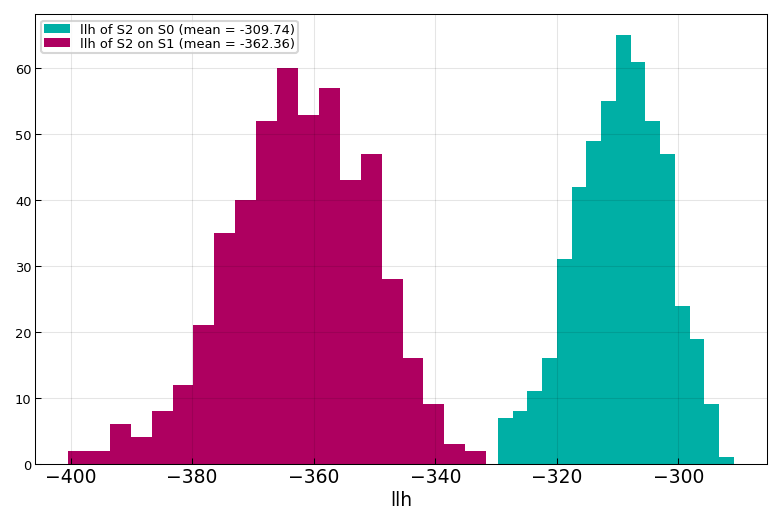

In [30]:

fig, ax = plt.subplots(1, figsize=set_size('full'))
bins = 20
ax.hist(llhs_S02_S00, color=usz_green, bins = bins, label = f"llh of S2 on S0 (mean = {np.mean(llhs_S02_S00) :.2f})")
ax.hist(llhs_S02_S01, color=usz_red, bins = bins, label = f"llh of S2 on S1 (mean = {np.mean(llhs_S02_S01) :.2f})")
ax.set_xlabel('llh')
plt.legend()

fig.savefig(PLOT_PATH / "hist_llh_S02_S00S01.svg")

## Create mixture model and fix mixture components to 1 for S00 and S01

In [84]:
global MODELS

graph = {
            ("tumor", "primary"): ["I", "II", "III"],
            ("lnl", "I"): [],
            ("lnl", "II"): ["I", "III"],
            ("lnl", "III"): [],
        }
models = create_models(3, graph = graph)

n_base_p = len(models[0].base_probs)
n_trans_p = len(models[0].trans_probs)
n_time_p = models[0].diag_time_dists.num_parametric
n_params_base = n_base_p + n_trans_p + n_time_p
ndim = n_params_base*2 + 1





In [85]:
# Load the data
for i, (s_name, s_data) in enumerate(data_s.items()):
    try:
        print(f"Loading data for subsite '{s_name}'.. Shape: {np.shape(s_data)}")
        models[i].patient_data = s_data
    except Exception as e:
        print(f"Error in loading data for cluster {s_name}.")
        print(e)
MODELS=models

Loading data for subsite 'S0'.. Shape: (190, 13)
Loading data for subsite 'S1'.. Shape: (350, 13)
Loading data for subsite 'S2'.. Shape: (202, 13)


In [86]:
C = np.array([[1,0], [0,1], [0.5, 0.5]])

emcee_args = [n_params_base, C] 

In [34]:
def log_prob_k_cluster(theta, n_graph_p, C):
    m = theta[-1]
    if m<0 or m> 1:
        return -np.inf
    C[2,0] = m
    C[2,1] = 1 - m
    llh = 0
    for s in range(3):
        model = MODELS[s]
        log_sum = 0
        pi0 = C[s,0]
        pi1 = C[s,1]
        params0 = theta[0: (1)*n_graph_p]
        params1 = theta[1*n_graph_p: (2)*n_graph_p]
        log_sum_0 = -np.inf
        log_sum_1 = -np.inf
        if pi0 != 0:
            log_sum_0 = np.log(pi0) + model.likelihood(given_params=params0, log = True)
        if pi1 != 0:
            log_sum_1 = np.log(pi1) + model.likelihood(given_params=params1, log = True)

        log_sum = np.logaddexp(log_sum_0, log_sum_1)
        # llh += ( C[s,k]*model.likelihood(given_params=params, log = True))
        llh += log_sum
    if np.isnan(llh):
        return -np.inf

    if np.isinf(llh):
        return -np.inf
    return llh

In [35]:
# check if likelihood function works
a = 0
param1 = np.array([0.0393634 , 0.07910263, 0.02163931, 0.05738574, 0.0466186 ,
       0.70873849, 0.0393634 , 0.07910263, 0.02163931, 0.05738574, 0.0466186 ,
       0.70873849, 0.5])
log_prob_k_cluster(param1, n_params_base, C)

-1255.4670283179325

In [36]:
nwalkers, nstep, burnin = 400, 1000, 200
print(f"Dimension: {ndim} with n walkers: {nwalkers}")
output_name = "samples_2_cluster_fix_s00s01_2123_stdd"

if True:
    samples = np.load("samples/"+output_name+".npy")
else:
    created_pool = mp.Pool(os.cpu_count())
    with created_pool as pool:
        starting_points = np.random.uniform(size=(nwalkers, ndim))
        print(f"Start Burning (steps = {burnin}) with {created_pool._processes} cores")
        burnin_sampler = emcee.EnsembleSampler(
            nwalkers,
            ndim,
            log_prob_k_cluster,
            args=emcee_args,
            pool=pool,
        )
        burnin_results = burnin_sampler.run_mcmc(
            initial_state=starting_points, nsteps=burnin, progress=True
        )
        
        ar = np.mean(burnin_sampler.acceptance_fraction)
        print(f"the HMM sampler for model 01 accepted {ar * 100 :.2f} % of samples.")
        last_sample = burnin_sampler.get_last_sample()[0]
        print(f"The shape of the last sample is {last_sample.shape}")
        starting_points = np.random.uniform(size=(nwalkers, ndim))
        original_sampler_mp = emcee.EnsembleSampler(
            nwalkers,
            ndim,
            log_prob_k_cluster,
            args=emcee_args,
            backend=None,
            pool=pool,
        )
        sampling_results = original_sampler_mp.run_mcmc(
            initial_state=last_sample, nsteps=nstep, progress=True
        )

    ar = np.mean(original_sampler_mp.acceptance_fraction)
    print(f"the HMM sampler for model accepted {ar * 100 :.2f} % of samples.")
    samples = original_sampler_mp.get_chain(flat=True)
    np.save(f"./samples/" + output_name, samples)
    # plots["acor_times"].append(burnin_info["acor_times"][-1])
    # plots["accept_rates"].append(burnin_info["accept_rates"][-1])


Dimension: 13 with n walkers: 400


In [37]:

samples_cl_0 = samples[:, :n_params_base]
samples_cl_1 = samples[:, n_params_base: 2*n_params_base]
mixing = samples[:,-1]

print(f"mean mixing pi20= {mixing.mean(axis =0 ) :.2f}")


mean mixing pi20= 0.62


In [38]:
model_labels = get_param_labels(models[0])
# model_labels = [label.replace("->", "➜") for label in model_labels]
model_labels = [label.replace("primary", "T") for label in model_labels]
model_labels.append(r'$\pi_{2,0}$') if '$\pi_{2,0}' not in model_labels else ''
model_labels

['T->I', 'T->II', 'T->III', 'II->I', 'II->III', 'late', '$\\pi_{2,0}$']

In [39]:
# truths = samples_S00.mean(axis = 0)
# truths = np.append(truths, 0)
# fig = corner.corner(
#     np.column_stack((samples_cl_0, mixing)),
#     labels=model_labels,
#     show_titles=True,
#     truths = truths
# )
# plt.show()
# fig.savefig(PLOT_PATH / "corner_samplesS0_2mixing_indp_2123_clb_clb_isb.svg")


model_labels[-1] = '1-pi'


In [40]:
# model_labels = get_param_labels(models[0])
# # model_labels = [label.replace("->", "➜") for label in model_labels]
# model_labels = [label.replace("primary", "T") for label in model_labels]
# model_labels.append(r'$\pi_{2,0}$') if '$\pi_{2,1}' not in model_labels else ''

# truths = samples_S01.mean(axis = 0)
# truths = np.append(truths, 0)

# fig = corner.corner(
#     np.column_stack((samples_cl_1, 1-mixing)),
#     labels=model_labels,
#     show_titles=True,
#     truths = truths
# )
# plt.show()
# fig.savefig(PLOT_PATH / "corner_samplesS01_2mixing_indp_2123_clb_clb_isb.svg")

### Try to really fix the parameters for sigma_0 and sigma_1

In [87]:
def log_prob_fixed_samples(theta, samples_0, samples_1):
    if theta > 1 or theta < 0:
        return -np.inf
    log_sum_0 = -np.inf
    log_sum_1 = -np.inf
    if theta != 0:
        log_sum_0 = np.log(theta) + MODELS[2].likelihood(given_params=samples_0, log = True)
    if theta!= 1:
        log_sum_1 = np.log(1-theta) + MODELS[2].likelihood(given_params=samples_1, log = True)
    log_sum = np.logaddexp(log_sum_0, log_sum_1)
    if np.isnan(log_sum):
        return -np.inf
    return log_sum

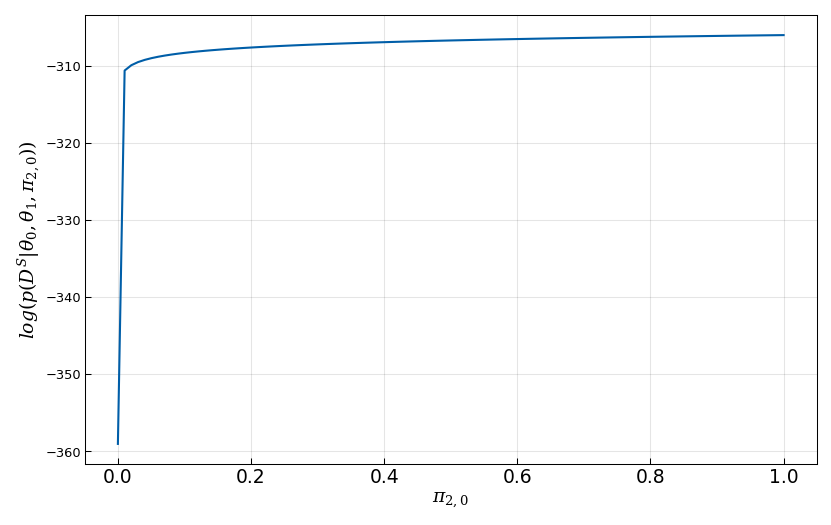

In [88]:
xs = np.linspace(0,1,100)
s0, s1 = samples_S00.mean(axis = 0), samples_S01.mean(axis = 0)
fig,ax = plt.subplots(1, figsize=set_size(width='full'))
ax.plot(xs, [log_prob_fixed_samples(x, s0, s1) for x in xs] , color = usz_blue)
ax.set_xlabel(r'$\pi_{2,0}$')
ax.set_ylabel(r'$log(p(D^S|{\theta_0, \theta_1, \pi_{2,0}}))$')
plt.show()
fig.savefig(PLOT_PATH / "line_llh_prob_dataS2_vs_mixing.svg")

In [91]:
import random
random_idx = random.sample(range(samples_S00.shape[0]), 100)

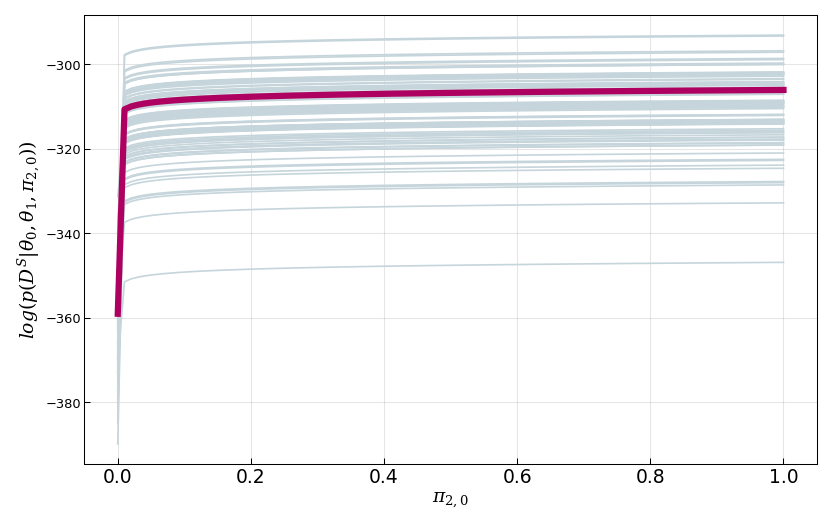

In [92]:
# How does it look like if we sample from the posterior?
n_lines = 100
random_idx = random.sample(range(len(samples_S00)), n_lines)

xs = np.linspace(0,1,100)
fig,ax = plt.subplots(1, figsize=set_size(width='full'))
for i in range(n_lines):
    ax.plot(xs, [log_prob_fixed_samples(x, samples_S00[random_idx[i]], samples_S01[random_idx[i]]) for x in xs] , color = usz_gray, linewidth = 0.8, linestyle = 'solid')
    
s0, s1 = samples_S00.mean(axis = 0), samples_S01.mean(axis = 0)
ax.plot(xs, [log_prob_fixed_samples(x, s0, s1) for x in xs] , color = usz_red, linewidth = 3)
ax.set_xlabel(r'$\pi_{2,0}$')
ax.set_ylabel(r'$log(p(D^S|{\theta_0, \theta_1, \pi_{2,0}}))$')
plt.show()
fig.savefig(PLOT_PATH / "line_llh_prob_dataS2_vs_mixing.svg")

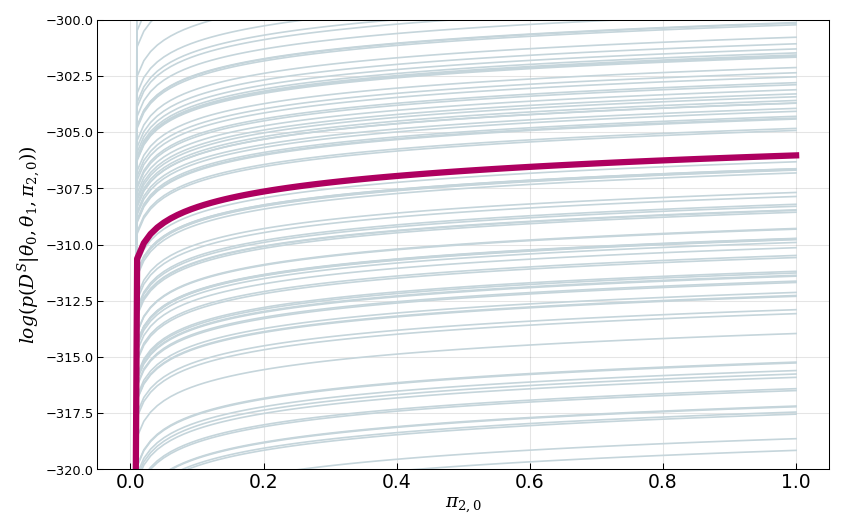

In [93]:
# How does it look like if we sample from the posterior?
n_lines = 100
random_idx = random.sample(range(len(samples_S00)), n_lines)

xs = np.linspace(0,1,100)
fig,ax = plt.subplots(1, figsize=set_size(width='full'))
for i in range(n_lines):
    ax.plot(xs, [log_prob_fixed_samples(x, samples_S00[random_idx[i]], samples_S01[random_idx[i]]) for x in xs] , color = usz_gray, linewidth = 0.8, linestyle = 'solid')
    
s0, s1 = samples_S00.mean(axis = 0), samples_S01.mean(axis = 0)
ax.plot(xs, [log_prob_fixed_samples(x, s0, s1) for x in xs] , color = usz_red, linewidth = 3)
ax.set_xlabel(r'$\pi_{2,0}$')
ax.set_ylabel(r'$log(p(D^S|{\theta_0, \theta_1, \pi_{2,0}}))$')
ax.set_ylim(bottom = -320, top = -300)
plt.show()
fig.savefig(PLOT_PATH / "line_llh_prob_dataS2_vs_mixing_cut.svg")

In [45]:
nwalkers, nstep, burnin = 25, 1000, 500
ndim_single = 1
print(f"Dimension: {ndim_single} with n walkers: {nwalkers}")
output_name = "samples_2_cluster_truefix_2123_stdd"

random_idx = random.sample(range(samples_S00.shape[0]), nstep)

if True:
    samples = np.load("samples/"+output_name+".npy")
else:
    log_prob_fun =log_prob_fixed_samples
    emcee_args = [samples_S00.mean(axis = 0), samples_S01.mean(axis = 0)]
    created_pool = mp.Pool(os.cpu_count())
    with created_pool as pool:
        starting_points = np.random.uniform(size=(nwalkers, ndim_single))
        print(f"Start Burning (steps = {burnin}) with {created_pool._processes} cores")
        burnin_sampler = emcee.EnsembleSampler(
            nwalkers,
            ndim_single,
            log_prob_fun,
            args=emcee_args,
            pool=pool,
        )
        burnin_results = burnin_sampler.run_mcmc(
            initial_state=starting_points, nsteps=burnin, progress=True
        )
        
        ar = np.mean(burnin_sampler.acceptance_fraction)
        print(f"the HMM sampler for model 01 accepted {ar * 100 :.2f} % of samples.")
        last_sample = burnin_sampler.get_last_sample()[0]
        print(f"The shape of the last sample is {last_sample.shape}")
        starting_points = np.random.uniform(size=(nwalkers, ndim_single))
        original_sampler_mp = emcee.EnsembleSampler(
            nwalkers,
            ndim_single,
            log_prob_fun,
            args=emcee_args,
            backend=None,
            pool=pool,
        )
        sampling_results = original_sampler_mp.run_mcmc(
            initial_state=last_sample, nsteps=nstep, progress=True
        )

    ar = np.mean(original_sampler_mp.acceptance_fraction)
    print(f"the HMM sampler for model accepted {ar * 100 :.2f} % of samples.")
    samples = original_sampler_mp.get_chain(flat=True)
    np.save(f"./samples/" + output_name, samples)
    # plots["acor_times"].append(burnin_info["acor_times"][-1])
    # plots["accept_rates"].append(burnin_info["accept_rates"][-1])

Dimension: 1 with n walkers: 25


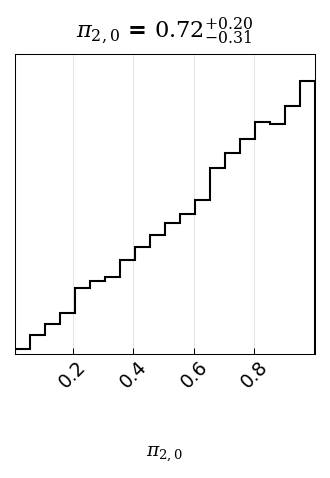

In [46]:

fig = corner.corner(
    samples,
    labels=[r'$\pi_{2,0}$'],
    show_titles=True,
)
plt.show()
fig.savefig(PLOT_PATH / "corner_single_mixing_true_fixed_theta.svg")

## Just check what happens if we sample all of the mixture components

In [47]:
global MODELS

graph = {
            ("tumor", "primary"): ["I", "II", "III"],
            ("lnl", "I"): [],
            ("lnl", "II"): ["I", "III"],
            ("lnl", "III"): [],
        }
models = create_models(3, graph = graph)

n_base_p = len(models[0].base_probs)
n_trans_p = len(models[0].trans_probs)
n_time_p = models[0].diag_time_dists.num_parametric
n_params_base = n_base_p + n_trans_p + n_time_p
ndim = n_params_base*2 + 1


# Load the data
for i, (s_name, s_data) in enumerate(data_s.items()):
    try:
        print(f"Loading data for subsite '{s_name}'.. Shape: {np.shape(s_data)}")
        models[i].patient_data = s_data
    except Exception as e:
        print(f"Error in loading data for cluster {s_name}.")
        print(e)
MODELS=models


Loading data for subsite 'S0'.. Shape: (190, 13)
Loading data for subsite 'S1'.. Shape: (350, 13)
Loading data for subsite 'S2'.. Shape: (202, 13)


In [105]:
n_clusters = 2
n_subsites = 3
ndim  = n_params_base*n_clusters + n_subsites

In [106]:
C = np.ones(shape=(n_subsites, n_clusters))*0.5
C

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]])

In [50]:
C = np.array([[1,0], [0,1], [0.5, 0.5]])

emcee_args = [n_params_base, n_clusters, n_subsites] 

In [95]:
def log_prob_k_cluster(theta, n_params_base, n_clusters, n_subsites):
    llh = 0
    for s in range(n_subsites):
        model = MODELS[s]
        log_sum = 0
        pi_s0 = theta[-s]
        pi_s1 = 1 - pi_s0    
        if pi_s0<0 or pi_s0> 1:
            return -np.inf
        params0 = theta[: n_params_base]
        params1 = theta[n_params_base: (2)*n_params_base]
        log_sum_0 = -np.inf
        log_sum_1 = -np.inf
        if pi_s0 != 0:
            log_sum_0 = np.log(pi_s0) + model.likelihood(given_params=params0, log = True)
        if pi_s1 != 0:
            log_sum_1 = np.log(pi_s1) + model.likelihood(given_params=params1, log = True)

        log_sum = np.logaddexp(log_sum_0, log_sum_1)
        # llh += ( C[s,k]*model.likelihood(given_params=params, log = True))
        llh += log_sum
    if np.isnan(llh):
        return -np.inf

    if np.isinf(llh):
        return -np.inf
    return llh

In [96]:
nwalkers, nstep, burnin = 400, 1000, 1500
print(f"Dimension: {ndim} with n walkers: {nwalkers}")
output_name = "samples_2_cluster_s0s1s2_nofix_2123_stdd"

if True:
    samples = np.load("samples/"+output_name+".npy")
else:
    created_pool = mp.Pool(os.cpu_count())
    with created_pool as pool:
        starting_points = np.random.uniform(size=(nwalkers, ndim))
        print(f"Start Burning (steps = {burnin}) with {created_pool._processes} cores")
        burnin_sampler = emcee.EnsembleSampler(
            nwalkers,
            ndim,
            log_prob_k_cluster,
            args=emcee_args,
            pool=pool,
        )
        burnin_results = burnin_sampler.run_mcmc(
            initial_state=starting_points, nsteps=burnin, progress=True
        )
        
        ar = np.mean(burnin_sampler.acceptance_fraction)
        print(f"the HMM sampler for model 01 accepted {ar * 100 :.2f} % of samples.")
        last_sample = burnin_sampler.get_last_sample()[0]
        print(f"The shape of the last sample is {last_sample.shape}")
        starting_points = np.random.uniform(size=(nwalkers, ndim))
        original_sampler_mp = emcee.EnsembleSampler(
            nwalkers,
            ndim,
            log_prob_k_cluster,
            args=emcee_args,
            backend=None,
            pool=pool,
        )
        sampling_results = original_sampler_mp.run_mcmc(
            initial_state=last_sample, nsteps=nstep, progress=True
        )

    ar = np.mean(original_sampler_mp.acceptance_fraction)
    print(f"the HMM sampler for model accepted {ar * 100 :.2f} % of samples.")
    samples = original_sampler_mp.get_chain(flat=True)
    np.save(f"./samples/" + output_name, samples)
    # plots["acor_times"].append(burnin_info["acor_times"][-1])
    # plots["accept_rates"].append(burnin_info["accept_rates"][-1])


Dimension: 13 with n walkers: 400


In [107]:
samples_nofix_cl0 = samples[:,:n_params_base]
samples_nofix_cl0 = samples[:,n_params_base:2*n_params_base]




In [108]:
mixing_params = np.column_stack([samples[:,-n_subsites:], 1-samples[:,-n_subsites:]])

In [109]:
mixing_params

array([[ 9.68810741e-02,  4.19931090e-01,  8.09834608e-01,
         9.03118926e-01,  5.80068910e-01,  1.90165392e-01],
       [ 7.34949756e+02,  8.27462347e-01,  3.29698994e-01,
        -7.33949756e+02,  1.72537653e-01,  6.70301006e-01],
       [ 1.74032839e-01,  4.62174477e-01,  4.22738426e-02,
         8.25967161e-01,  5.37825523e-01,  9.57726157e-01],
       ...,
       [ 1.08387705e-01,  5.14325983e-01,  8.11462458e-01,
         8.91612295e-01,  4.85674017e-01,  1.88537542e-01],
       [ 2.91854597e+05,  8.44041227e-01,  9.66992840e-01,
        -2.91853597e+05,  1.55958773e-01,  3.30071600e-02],
       [-7.55593130e+04,  8.95329095e-01,  9.84624833e-01,
         7.55603130e+04,  1.04670905e-01,  1.53751666e-02]])

In [111]:
model_labels = get_model_labels(models)
mixing_labels = [r'$\pi_{00}$', r'$\pi_{10}$', r'$\pi_{20}$', r'$\pi_{01}$', r'$\pi_{11}$', r'$\pi_{21}$']

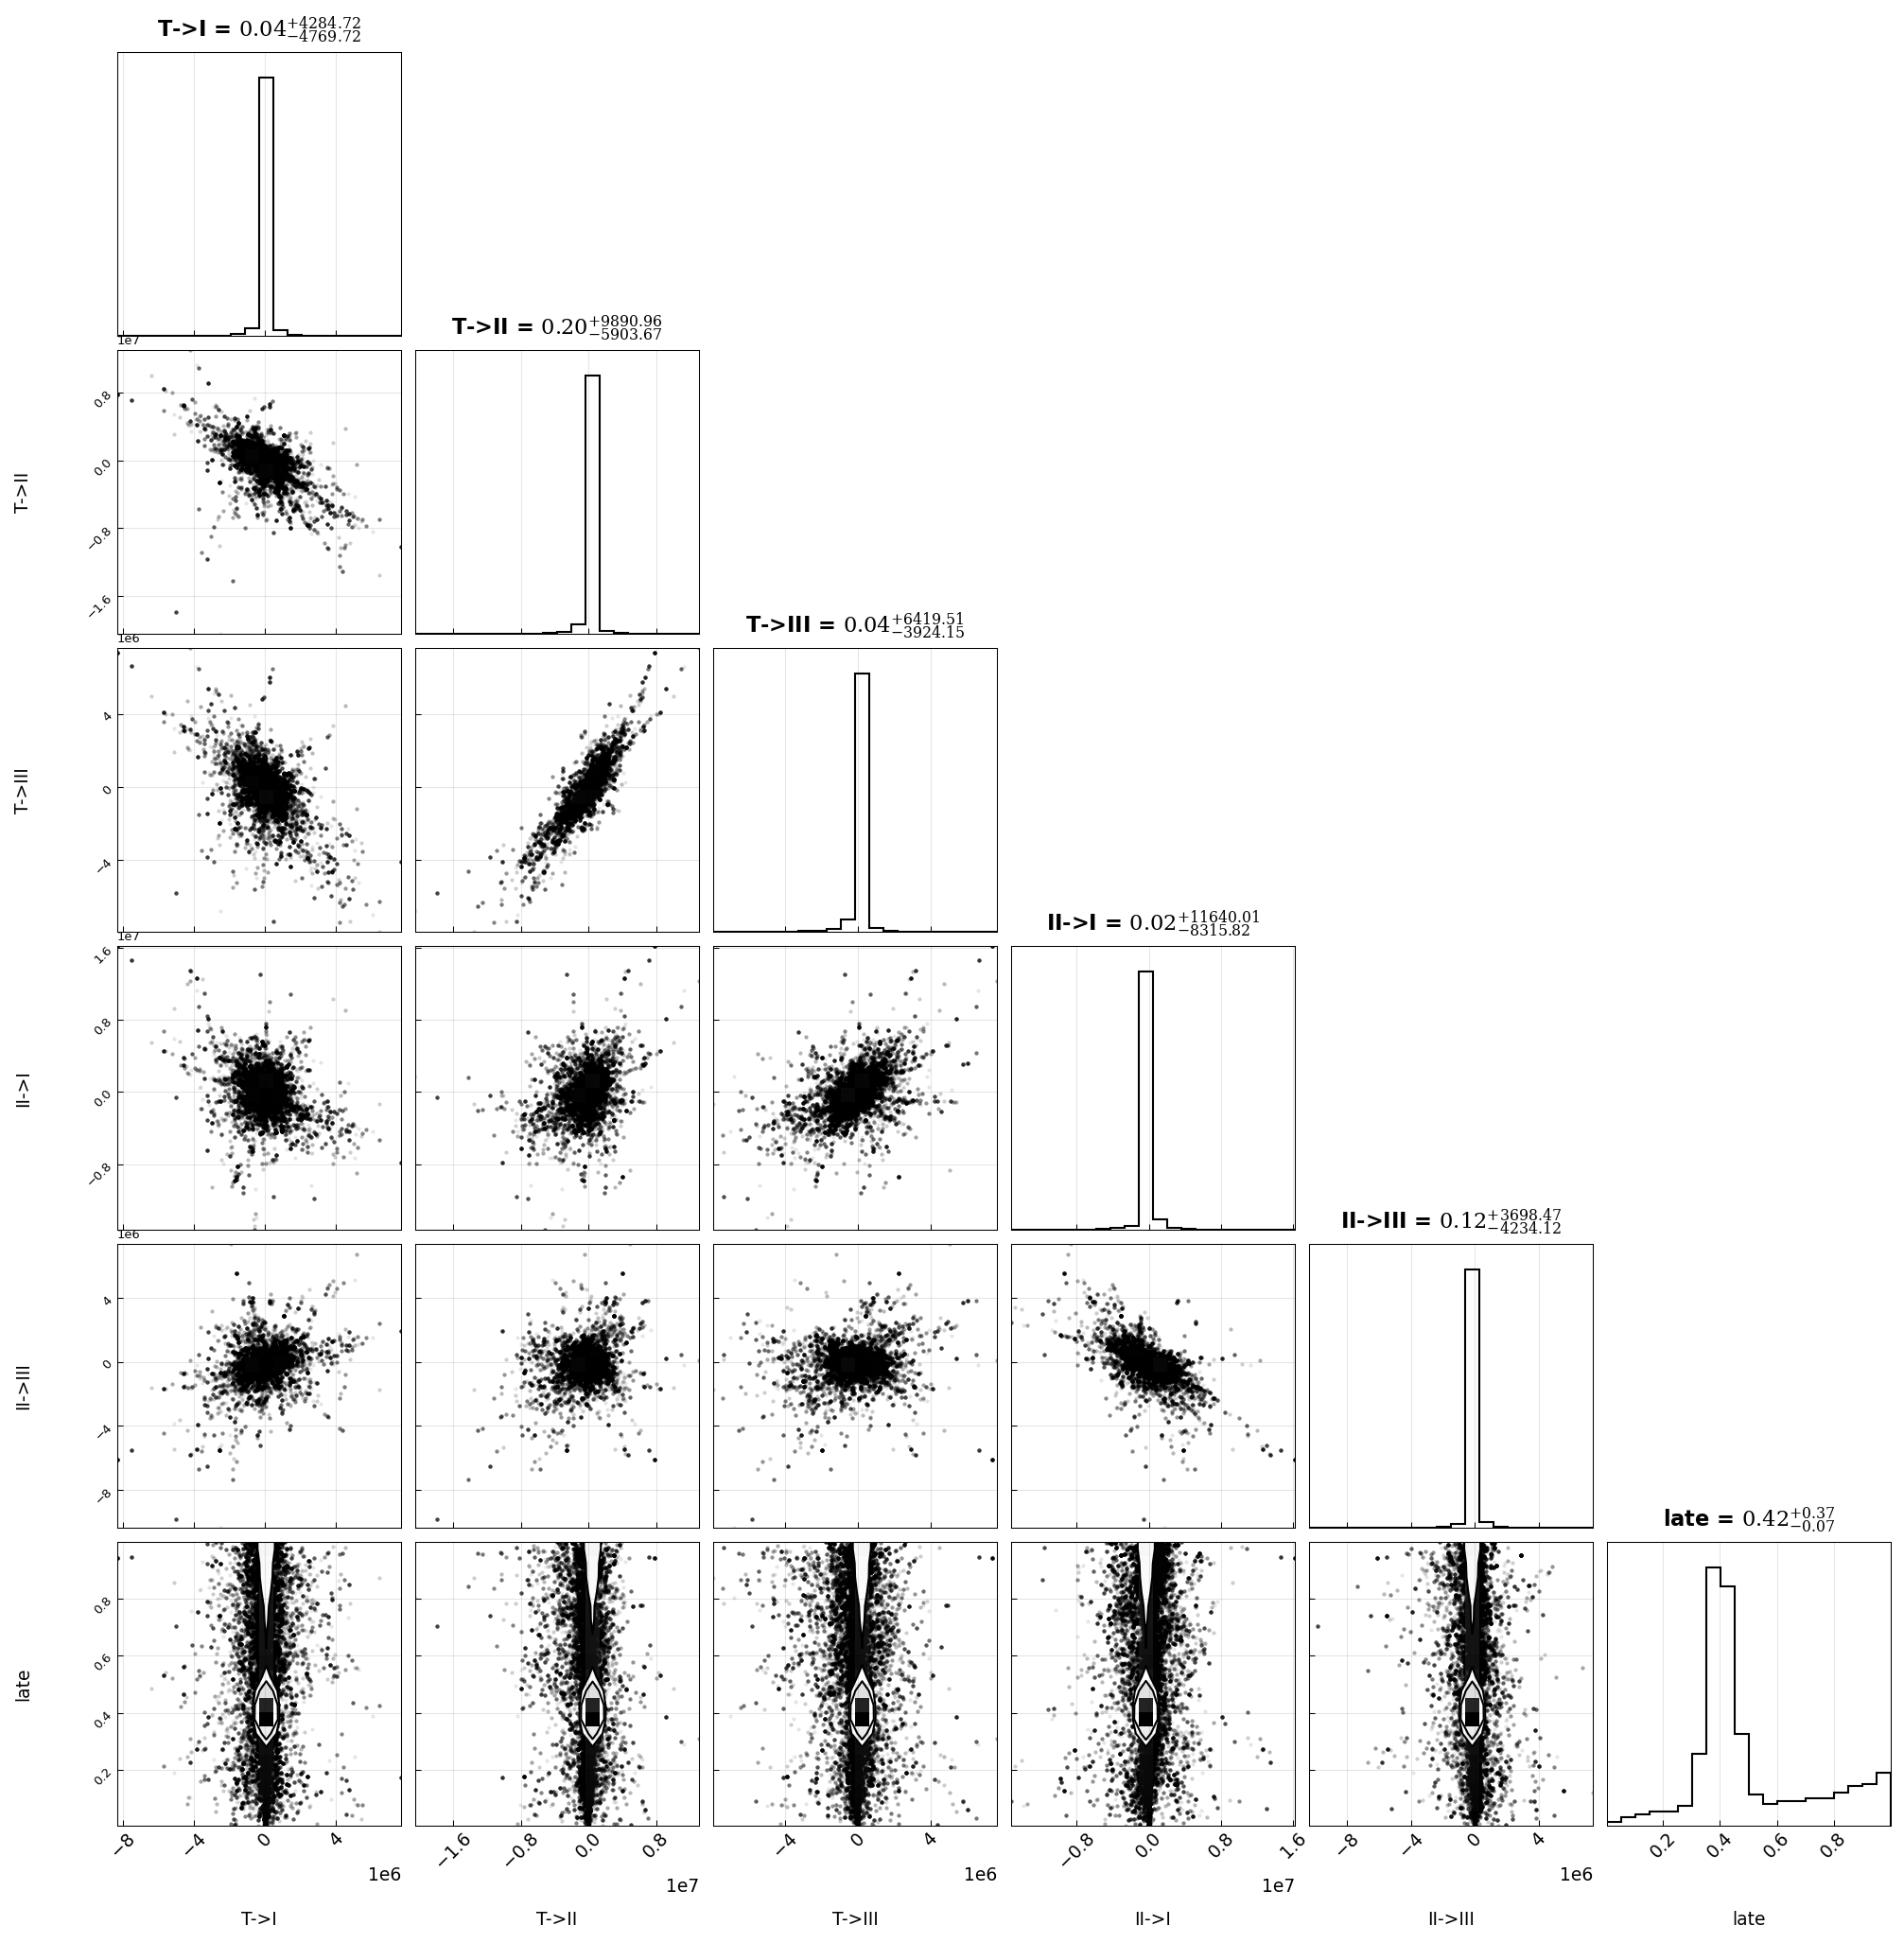

In [101]:
fig = corner.corner(
    data = samples_nofix_cl0,
    labels = model_labels,
    show_titles=True
)
plt.show()
fig.savefig(PLOT_PATH / "corner_samples_nofix_cl0_2_cluster_s0s1s2_nofix_2123_stdd.svg")

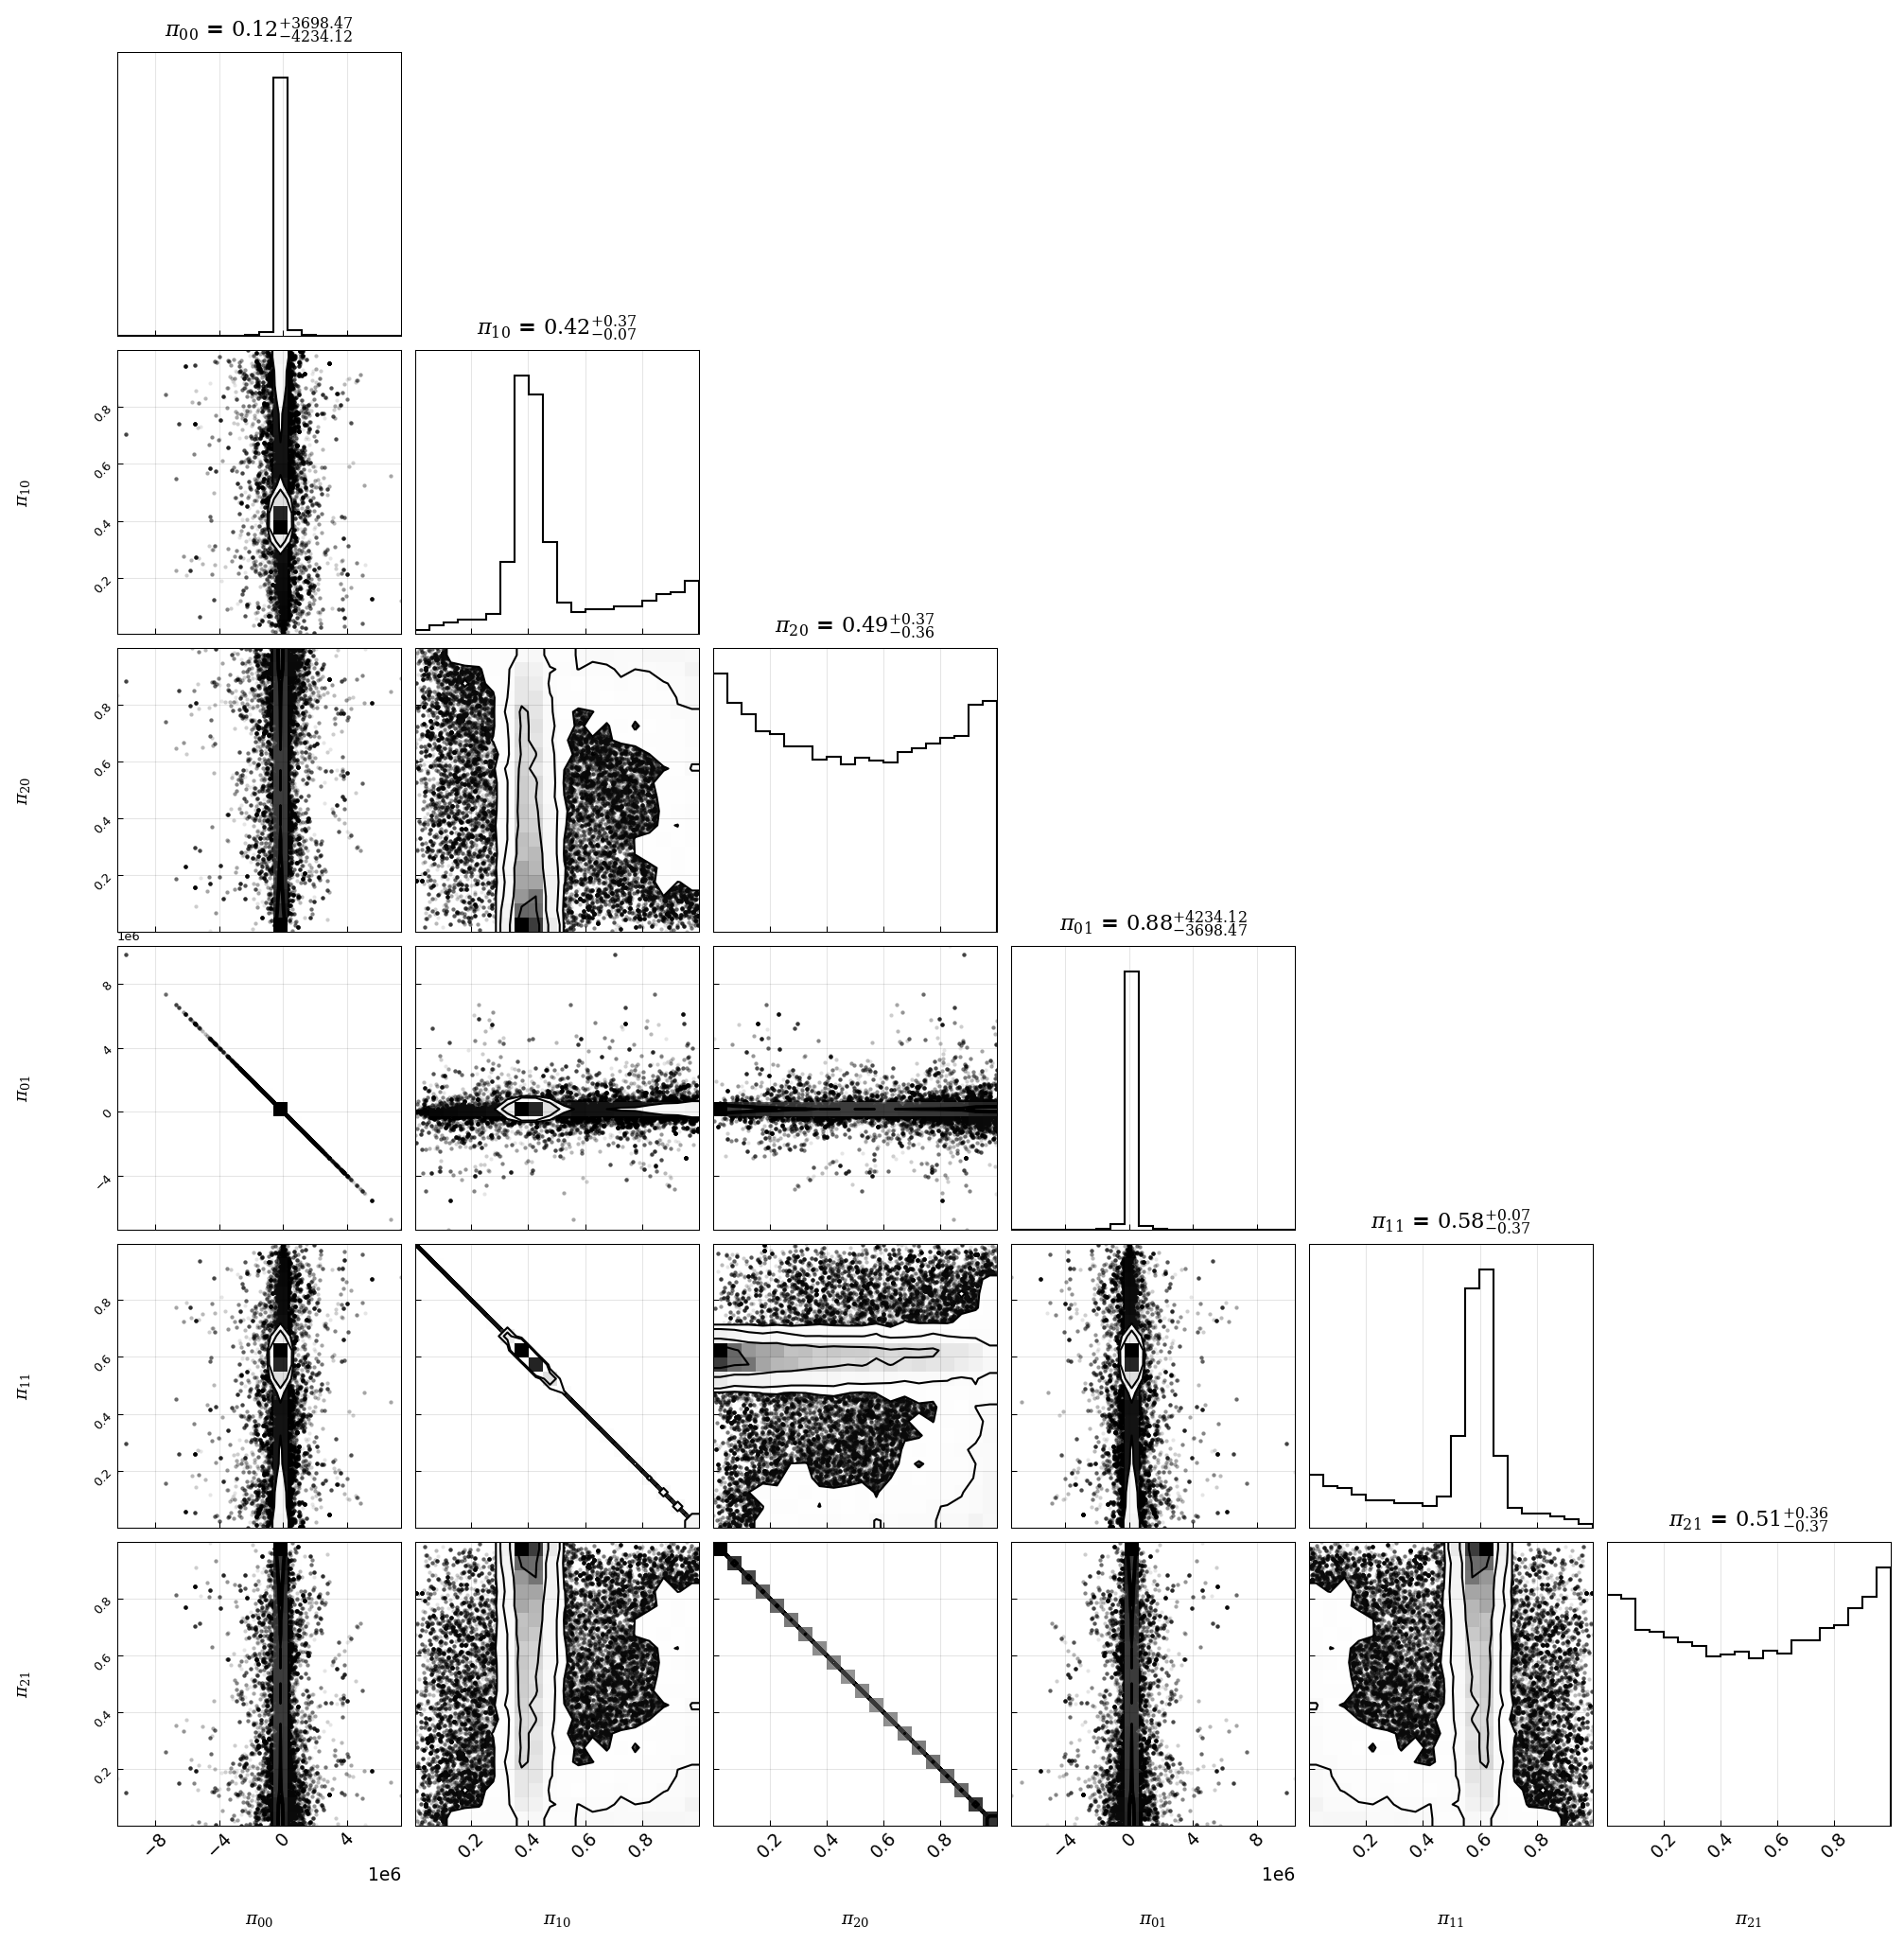

In [112]:
fig = corner.corner(
    data = mixing_params,
    labels = mixing_labels,
    show_titles=True
)
plt.show()
fig.savefig(PLOT_PATH / "corner_mixing_params_2_cluster_s0s1s2_nofix_2123_stdd.svg")

In [75]:
# Looks shit, as expected

In [ ]:
## Use the new lymph package (lymph_forked (version V1.0.01)) to continue.

In [4]:
import sys
sys.path.append("/Users/juli/Studium/Master/FS23/masterthesis/code/lymph_forked")  
import lymph_forked


In [31]:
graph = {
            ("tumor", "primary"): ["I", "II", "III"],
            ("lnl", "I"): [],
            ("lnl", "II"): ["I", "III"],
            ("lnl", "III"): [],
        }

In [32]:
model = lymph_forked.models.Unilateral(graph_dict=graph)

In [36]:
pathological_spsn = {
        "max_llh": [1.0, 1.0],
    }
model.modalities = pathological_spsn
print(model.modalities['max_llh'])

[[1. 0.]
 [0. 1.]]


In [44]:
import scipy as sp

In [57]:


def late_binomial(support: np.ndarray, p: float = 0.5) -> np.ndarray:
    """Parametrized binomial distribution."""
    n = support[-1]
    pmf = np.fromiter((np.math.comb(n, k) * np.power(p, k) * np.power(1 - p, n - k) for k in support), dtype=float)
    return pmf


def create_models_forked(n,  graph = None):
    if graph is None:
        graph = {
            ("tumor", "primary"): ["I", "II", "III", "IV"],
            ("lnl", "I"): [],
            ("lnl", "II"): ["I", "III"],
            ("lnl", "III"): ["IV"],
            ("lnl", "IV"): [],
        }

    diagnostic_spsn = {
        "max_llh": [1.0, 1.0],
    }


    max_t = 10
    first_binom_prob = 0.3

    models = []
    for i in range(n):
        model = lymph_forked.models.Unilateral(graph_dict=graph)
        model.modalities = diagnostic_spsn

        max_time = model.max_time
        time_steps = np.arange(max_time+1)
        p = 0.4

        early_prior = sp.stats.binom.pmf(time_steps, max_time, p)
        model.diag_time_dists["early"] = early_prior
        model.diag_time_dists["late"] = late_binomial
        
        models.append(model)
    if n>1:
        return models
    else:
        return models[0]

In [58]:
model = create_models_forked(1, graph = graph)
model.get_params(as_dict=True)

/Users/juli/Studium/Master/FS23/masterthesis/code/lymph_forked/lymph_forked/descriptors/diagnose_times.py:140: UserWarning: Distribution is not updateable, returning empty dict
  warnings.warn("Distribution is not updateable, returning empty dict")


{'spread_primary_to_I': 0.0,
 'spread_primary_to_II': 0.0,
 'spread_primary_to_III': 0.0,
 'spread_II_to_I': 0.0,
 'spread_II_to_III': 0.0,
 'late_p': 0.5}

In [63]:

data_s0_s1_tf = pd.concat([data_s['S0'],data_s['S1'] ])


In [74]:
model.load_patient_data(data, side='ipsi')

In [75]:
model.patient_data['_model']

max_llh                     #
          I     II    III t_stage
0     False  False  False   early
1     False  False  False   early
2     False  False  False   early
3      True  False   True    late
4     False  False  False   early
..      ...    ...    ...     ...
964   False   True  False   early
965   False  False  False    late
966   False  False  False   early
967   False  False  False   early
968   False  False   True   early

[969 rows x 4 columns]

## Create Synthetic dataset

In [130]:
graph = {
    ("tumor", "primary"): ["I", "II", "III"],
    ("lnl", "I"): [],
    ("lnl", "II"): ["I", "III"],
    ("lnl", "III"): [],
}
lnls = ['I', 'II', 'III']

In [126]:
model = create_models_forked(1, graph=graph)
model.get_params(as_dict=True)

/Users/juli/Studium/Master/FS23/masterthesis/code/lymph_forked/lymph_forked/descriptors/diagnose_times.py:140: UserWarning: Distribution is not updateable, returning empty dict
  warnings.warn("Distribution is not updateable, returning empty dict")


{'spread_primary_to_I': 0.0,
 'spread_primary_to_II': 0.0,
 'spread_primary_to_III': 0.0,
 'spread_II_to_I': 0.0,
 'spread_II_to_III': 0.0,
 'late_p': 0.5}

In [117]:
params_s0 = [0.5, 0, 0.05, 0.00, 0.1, 0.5]
params_s1 = [0, 0.5, 0.05, 0.00, 0.1, 0.5]
# params_s2 = [0.2, 0.02, 0.05, 0.00, 0.1, 0.5]

t_dist = {'early': 0.6, 'late': 0.4}

In [133]:
model.assign_params(*params_s0)
data_synth_s0 = model.generate_dataset(150, t_dist)
data_synth_s0.head()

max_llh                  info
        I     II    III t_stage
0   False  False   True   early
1    True  False  False    late
2   False  False  False   early
3    True  False   True    late
4    True  False  False   early

 State: {'III': 1, 'II': 1, 'I': 1}

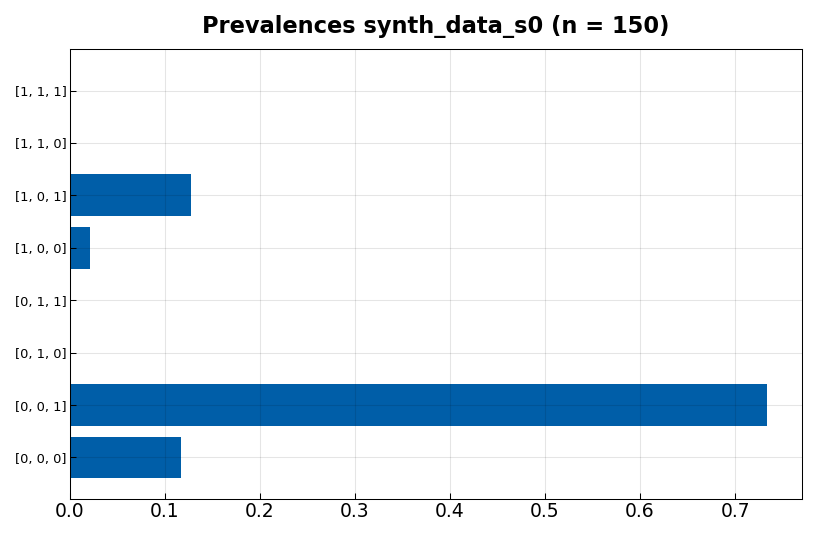

In [134]:
prev_synth_s0 = create_prev_vectors(data_synth_s0, lnls,  plot=True, title='synth_data_s0')

In [135]:
model.assign_params(*params_s1)
data_synth_s1 = model.generate_dataset(150, t_dist)
data_synth_s1.head()

max_llh                 info
        I    II    III t_stage
0   False  True  False   early
1   False  True  False    late
2   False  True  False   early
3   False  True  False    late
4   False  True   True    late

 State: {'III': 1, 'II': 1, 'I': 1}

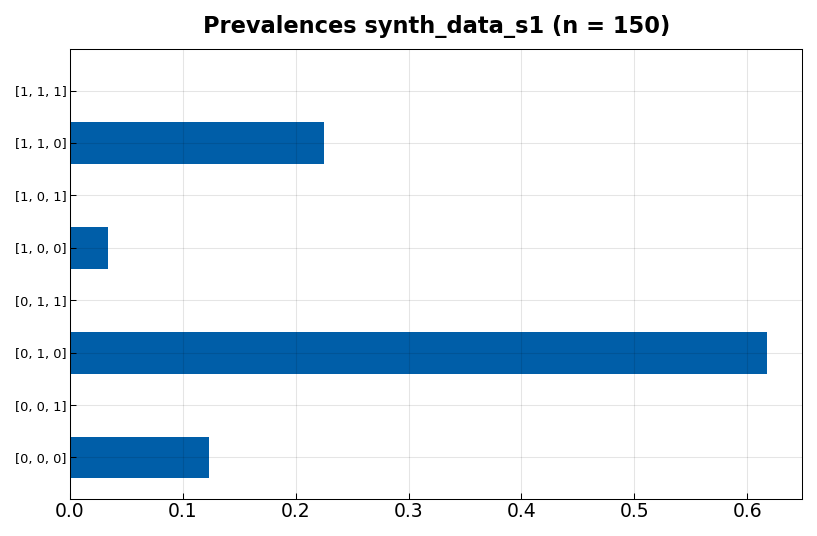

In [136]:
prev_synth_s1 = create_prev_vectors(data_synth_s1, lnls,  plot=True, title='synth_data_s1')

In [141]:
model.assign_params(*params_s0)
data_synth_s0_30 = model.generate_dataset(30, t_dist)
model.assign_params(*params_s1)
data_synth_s1_30 = model.generate_dataset(30, t_dist)

data_synth_s2 = pd.concat([data_synth_s0_30, data_synth_s1_30], ignore_index=True)
data_synth_s2.head()

max_llh                  info
        I     II    III t_stage
0    True  False  False   early
1    True  False  False   early
2    True  False  False   early
3    True  False  False   early
4    True  False  False    late

 State: {'III': 1, 'II': 1, 'I': 1}

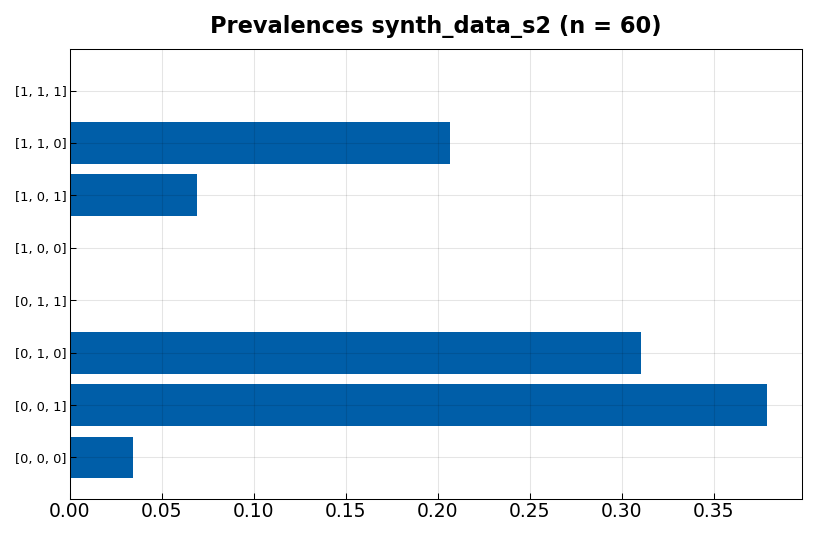

In [142]:
prev_synth_s2 = create_prev_vectors(data_synth_s2, lnls,  plot=True, title='synth_data_s2')

In [143]:
n_params_base = len(model.get_params(as_dict=True))

/Users/juli/Studium/Master/FS23/masterthesis/code/lymph_forked/lymph_forked/descriptors/diagnose_times.py:140: UserWarning: Distribution is not updateable, returning empty dict
  warnings.warn("Distribution is not updateable, returning empty dict")


In [ ]:
models = create_models_forked(3, graph)
n_params_base = len(model.get_params(as_dict=True))
n_base_p = len(models[0].base_probs)
n_trans_p = len(models[0].trans_probs)
n_time_p = models[0].diag_time_dists.num_parametric
n_params_base = n_base_p + n_trans_p + n_time_p
ndim = n_params_base*2 + 1
